In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [22]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

## Load extracted features and df

In [23]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [24]:
from utils.inverted_encoding import FeatureDowngrade

d2_H, d2_W = 15, 15
DEFAULT_FEATURE_CONV_CONFIG = {
    '0d': { 'old': np.array([0, 1]),},
    '1d': {
        'old': np.arange(2, 32),
        'zoom_ratio': 1.0,
    },
    '2d': {
        'old': np.arange(32, 32+d2_H*d2_W),
        'H': d2_H,
        'W': d2_W,
        'zoom_ratio': 0.4,
    }    
}

DEFAULT_FEA_CONVERTER = FeatureDowngrade(DEFAULT_FEATURE_CONV_CONFIG)

In [25]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 1), 'features')

from utils.rsa import ConditionalRSAFullHelper

class GazeRsaHelper(ConditionalRSAFullHelper):
    def load_subj_feature(self,
            subj, time_steps, normalize=True, converter=DEFAULT_FEA_CONVERTER):
        feature_loaded = []
        subj_result_folder = os.path.join(DEFAULT_FEATURE_FOLDER, f'{int(subj)}')
        subj_combined_feature_path = os.path.join(subj_result_folder, 'combined')
        for tid in time_steps:
            loaded = np.load(os.path.join(subj_combined_feature_path, f'{tid}.npy'))
            feature_loaded.append(loaded)
        features = np.mean(feature_loaded, axis=0) # time average

        if normalize:
            # Z-score normalization
            means = np.mean(features, axis=0)  # Mean of each column
            stds = np.std(features, axis=0)    # Standard deviation of each column
            features = (features - means) / (stds + 1e-5)

        # apply conversion if needed
        if converter is not None:
            features = converter.get_converted_features(features)
            
        # also the behavior data
        behavior_data = pd.read_csv(os.path.join(subj_result_folder, 'behavior.csv'))

        return features, behavior_data

    def get_subj_data_loader(self, subj, all_time_windows):
        for step_window in all_time_windows:
            features, behavior_data = self.load_subj_feature(subj, step_window)
            yield features, behavior_data

In [26]:
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

## Precompute the difference table

In [27]:
from utils.distrib import ValueRangeManager, OriDistribModel, incorporate_distributions
from copy import deepcopy

example_base_params = {"w": 0.14, "k_base": 27, "alpha": 1.0, "beta": 0.0,}
value_manager = ValueRangeManager(np.arange(180))
base_distrib = OriDistribModel(value_manager, example_base_params)

In [28]:
all_oris = np.arange(180)
all_distrib = base_distrib.loc(all_oris)

In [29]:
# apply some smoothing
from scipy.ndimage import gaussian_filter1d

def gaussian_filter_distrib(distrib, sigma):
    smoothed = gaussian_filter1d(distrib, sigma=sigma, axis=1, mode='wrap')
    smoothed = smoothed / np.sum(smoothed, axis=1, keepdims=True)
    return smoothed

# all_distrib = gaussian_filter_distrib(all_distrib, sigma=15)

In [30]:
from scipy.spatial.distance import pdist, cdist, jensenshannon, squareform

def precomput_stim_dists(distrib, method):
    if method == 'jsd':
        dists = squareform(pdist(distrib, metric=jensenshannon))
        dists = dists / np.log(2)
    elif method == 'cos':
        distrib_normalized = distrib / np.linalg.norm(distrib, axis=1, keepdims=True)
        similarity = np.dot(distrib_normalized, distrib_normalized.T)
        dists = 1 - similarity
    elif method == 'euc':
        dists = cdist(distrib, distrib, 'euclidean')
    else:
        raise ValueError(f'Unknown method {method}')

    return dists

(array([  636.,   614.,   644.,   584.,   654.,   620.,   624.,   654.,
          672.,   672.,   718.,   736.,   798.,   844.,   918.,   998.,
         1142.,  1408.,  2364., 16100.]),
 array([0.        , 0.05217422, 0.10434844, 0.15652265, 0.20869687,
        0.26087109, 0.31304531, 0.36521952, 0.41739374, 0.46956796,
        0.52174218, 0.5739164 , 0.62609061, 0.67826483, 0.73043905,
        0.78261327, 0.83478748, 0.8869617 , 0.93913592, 0.99131014,
        1.04348435]),
 <BarContainer object of 20 artists>)

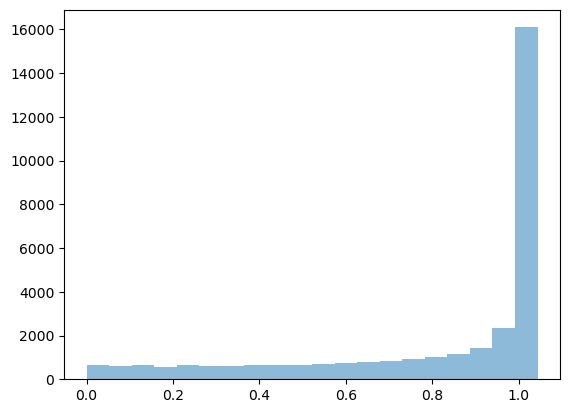

In [31]:
all_ori_dists = precomput_stim_dists(all_distrib, 'jsd')
plt.hist(all_ori_dists.flatten(), bins=20, alpha=0.5)

## Apply RSA within a certain condition

In [32]:
from copy import deepcopy

In [33]:
from utils.rsa import RepresentationModel

distrib_params = {"w": 0.14, "k_base": 27, "alpha": 1.0, "beta": 0.0,}
RepModel = RepresentationModel(distrib_params)

In [34]:
from utils.rsa import RepRSAHelper

rsa_configs = {
    "channels": 18, # number of channels
    "channel_k": 5, # to compute weight for channels
}
rsa_helper = RepRSAHelper(**rsa_configs, rep_model=RepModel)

In [35]:
from utils.rsa import ALL_TIME_STEPS
PLOT_TIME_STEPS = ALL_TIME_STEPS[1:-1]

In [36]:
full_rsa_helper = GazeRsaHelper(
    rsa_helper=rsa_helper,
    plot_time_steps=PLOT_TIME_STEPS,
    plot_window_size=3,
    permutation_level=0,
)

In [37]:
draw_lmb = lambda d: (d['mode'] == 'draw').to_numpy()
feature_mask = np.arange(0, 2)
example_results = full_rsa_helper.conditional_rsa_subj(
    908, draw_lmb, feature_mask, 'stim_1', 'euc')

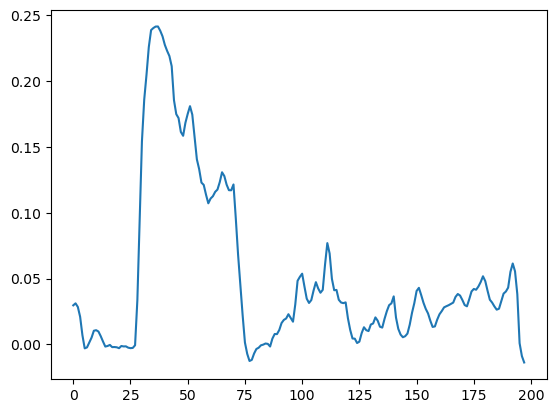

In [38]:
plt.plot(example_results[0])

## Combine everyone

In [39]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'rsa', 'within_group')

In [40]:
display_time_steps=(PLOT_TIME_STEPS+0.5)*50

In [41]:
from utils.rsa import RSA_PLOT_SIZE
from collections import OrderedDict

ALL_FEATURE_MASKS = OrderedDict([
    # ('mean location', np.arange(0, 2)),
    # ('angle distrib', np.arange(2, 32)),
    ('1d2d', np.arange(32, 68)),
])

ALL_FEATURE_MASK_DIST_METHODS = OrderedDict([
    # ('mean location', 'euc'),
    # ('angle distrib', 'cos'),
    ('1d2d', 'cos'),
])

def display_gaze_rsa_plots(
        feature_masks=ALL_FEATURE_MASKS,
        feature_mask_dist_methods=ALL_FEATURE_MASK_DIST_METHODS,
        lmb_masks={}, color_dicts={}, alpha_dicts={}, linestyles_dicts={}, 
        plot_name='', compare_pairs=False):
    
    for feature_name in feature_masks:
        fig, ax = plt.subplots(1, 1, figsize=RSA_PLOT_SIZE)
        to_show_legend = True

        n_sigs_plotted = 0
        sig_y_start = 0.15
        sig_y_step = 0.02 if compare_pairs else 0.01

        for stim_id in lmb_masks:
            # set styles for significance plot
            lmb_dicts = lmb_masks[stim_id]
            sig_yoffsets = {}
            pairs_to_compare = []
            pairwise_sig_styles = []
            
            # individual comparison
            lmb_names = list(lmb_dicts.keys())
            for i, k in enumerate(lmb_names):
                sig_yoffsets[k] = sig_y_start + (n_sigs_plotted+i) * sig_y_step
            
            if compare_pairs:
                assert len(lmb_names) == 2, "For pairwise comparison, exactly two conditions are required."
                pairs_to_compare.append(lmb_names)
                pairwise_sig_styles.append({
                    'yoffset': sig_y_start + (n_sigs_plotted + 0.5) * sig_y_step,
                    'color': 'gray',
                    'alpha': np.mean(list(alpha_dicts[stim_id].values())) * 0.7, # make it less visible?
                    'linestyle': linestyles_dicts[stim_id][lmb_names[0]],
                })

            # plot it
            full_rsa_helper.display_lmb_dicts_rsa(
                ax=ax, lmb_dicts=lmb_dicts, 
                feature_mask=feature_masks[feature_name], 
                y_name=stim_id, 
                feature_dist_method=feature_mask_dist_methods[feature_name], 
                subjs=all_subjs,
                display_time_steps=display_time_steps,
                colors=color_dicts[stim_id], 
                alphas=alpha_dicts[stim_id],
                linestyles=linestyles_dicts[stim_id],
                sig_yoffsets=sig_yoffsets,
                show_legend=to_show_legend,
                comparison_sig_pairs=pairs_to_compare,
                pairwise_sig_styles=pairwise_sig_styles,
            )
            
            # update count of significance lines
            n_sigs_plotted += len(lmb_dicts) + 0.1 # some group offset

        plot_path = os.path.join(PLOTS_FOLDER, f'{plot_name}_{feature_name}.png')
        plt.savefig(plot_path, bbox_inches='tight')

In [42]:
draw_lmb = lambda d: (d['mode'] == 'draw').to_numpy()
click_lmb = lambda d: (d['mode'] == 'click').to_numpy()

### sanity check

In [43]:
from utils.eye_plotting import STIM1_COLOR, STIM2_COLOR

stim1_valid_lmb = lambda d: ((d['stim_1_to_report'] | (d['trial_code'] == 1))).to_numpy()
stim1_invalid_lmb = lambda d: (~(stim1_valid_lmb(d)))
stim2_valid_lmb = lambda d: ((d['stim_2_to_report'] | (d['trial_code'] == 1))).to_numpy()
stim2_invalid_lmb = lambda d: (~(stim2_valid_lmb(d)))
valid_masks = {
    'stim_1': {
        'valid, stim 1': stim1_valid_lmb,
        'invalid, stim 1': stim1_invalid_lmb,
    },
    'stim_2': {
        'valid, stim 2': stim2_valid_lmb,
        'invalid, stim 2': stim2_invalid_lmb,
    }
}

valid_colors = {
    'stim_1': {
        'valid, stim 1': STIM1_COLOR, # 'purple',
        'invalid, stim 1': STIM1_COLOR, # 'purple',
    },
    'stim_2': {
        'valid, stim 2': STIM2_COLOR, # 'green',
        'invalid, stim 2': STIM2_COLOR, # 'green',
    }
}

valid_alphas = {
    'stim_1': {
        'valid, stim 1': 1.0,
        'invalid, stim 1': 0.5,
    },
    'stim_2': {
        'valid, stim 2': 1.0,
        'invalid, stim 2': 0.5,
    }
}

valid_linestyles = {
    'stim_1': {
        'valid, stim 1': '-',
        'invalid, stim 1': '--',
    },
    'stim_2': {
        'valid, stim 2': '-',
        'invalid, stim 2': '--',
    }
}


100%|██████████| 36/36 [01:18<00:00,  2.18s/it]


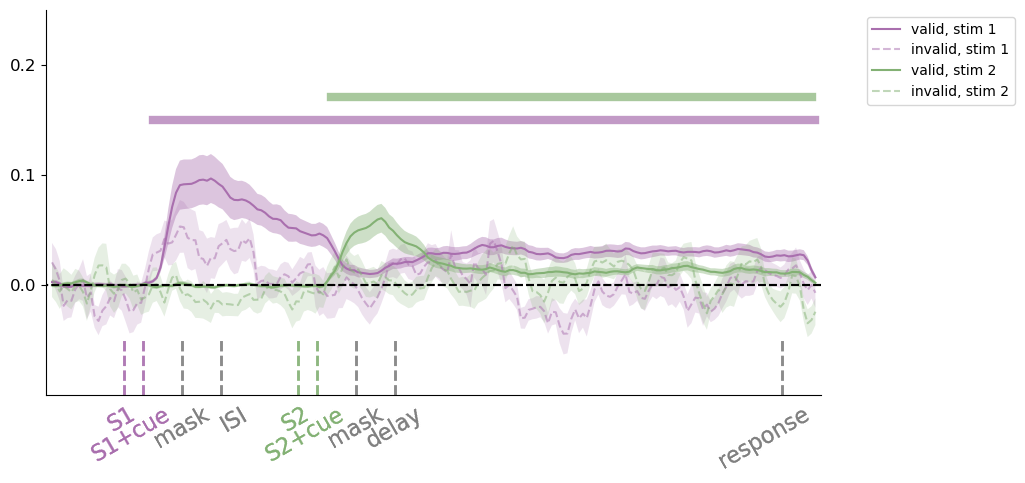

In [44]:
display_gaze_rsa_plots(
    lmb_masks=valid_masks, 
    color_dicts=valid_colors, 
    alpha_dicts=valid_alphas, 
    linestyles_dicts=valid_linestyles, 
    plot_name='basic', 
    compare_pairs=False)

### mode comparison

In [45]:
draw_stim1_lmb = lambda d: (
    (d['mode'] == 'draw') & (d['stim_1_to_report'] | (d['trial_code'] == 1))).to_numpy()
click_stim1_lmb = lambda d: (
    (d['mode'] == 'click') & (d['stim_1_to_report'] | (d['trial_code'] == 1))).to_numpy()
draw_stim2_lmb = lambda d: (
    (d['mode'] == 'draw') & (d['stim_2_to_report'] | (d['trial_code'] == 1))).to_numpy()
click_stim2_lmb = lambda d: (
    (d['mode'] == 'click') & (d['stim_2_to_report'] | (d['trial_code'] == 1))).to_numpy()

In [46]:
mode_masks = {
    'stim_1': {
        'draw, stim 1': draw_stim1_lmb,
        'wheel, stim 1': click_stim1_lmb,
    },
    'stim_2': {
        'draw, stim 2': draw_stim2_lmb,
        'wheel, stim 2': click_stim2_lmb,
    }
}

mode_colors = {
    'stim_1': {
        'draw, stim 1': 'skyblue',
        'wheel, stim 1': 'coral',
    },
    'stim_2': {
        'draw, stim 2': 'skyblue',
        'wheel, stim 2': 'coral',
    }
}

mode_alphas = {
    'stim_1': {
        'draw, stim 1': 1.0,
        'wheel, stim 1': 1.0,
    },
    'stim_2': {
        'draw, stim 2': 0.5,
        'wheel, stim 2': 0.5,
    }
}

mode_linestyles = {
    'stim_1': {
        'draw, stim 1': '-',
        'wheel, stim 1': '-',
    },
    'stim_2': {
        'draw, stim 2': ':',
        'wheel, stim 2': ':',
    }
}

100%|██████████| 36/36 [01:20<00:00,  2.25s/it]


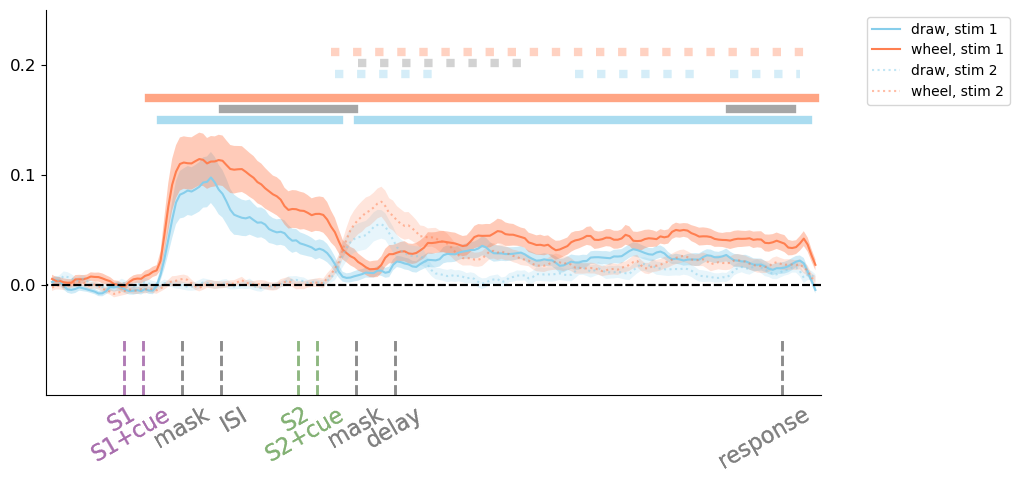

In [47]:
display_gaze_rsa_plots(
    lmb_masks=mode_masks, 
    color_dicts=mode_colors, 
    alpha_dicts=mode_alphas, 
    linestyles_dicts=mode_linestyles,
    plot_name='mode', 
    compare_pairs=True)

In [29]:
sd_mode_masks = {
    'prev_last_response': {
        'draw': draw_lmb,
        'click': click_lmb,
    },
}

sd_mode_colors = {
    'prev_last_response': {
        'draw': 'skyblue',
        'click': 'coral',
    },
}

sd_alphas = {
    'prev_last_response': {
        'draw': 1.0,
        'click': 1.0,
    },
}

sd_linestyles = {
    'prev_last_response': {
        'draw': '-',
        'click': '-',
    },
}

SD_FEATURE_MASKS = OrderedDict([
    ('mean location', np.arange(0, 2)),
    ('1d2d', np.arange(32, 68)),
])

SD_FEATURE_MASK_DIST_METHODS = OrderedDict([
    ('mean location', 'euc'),
    ('1d2d', 'cos'),
])

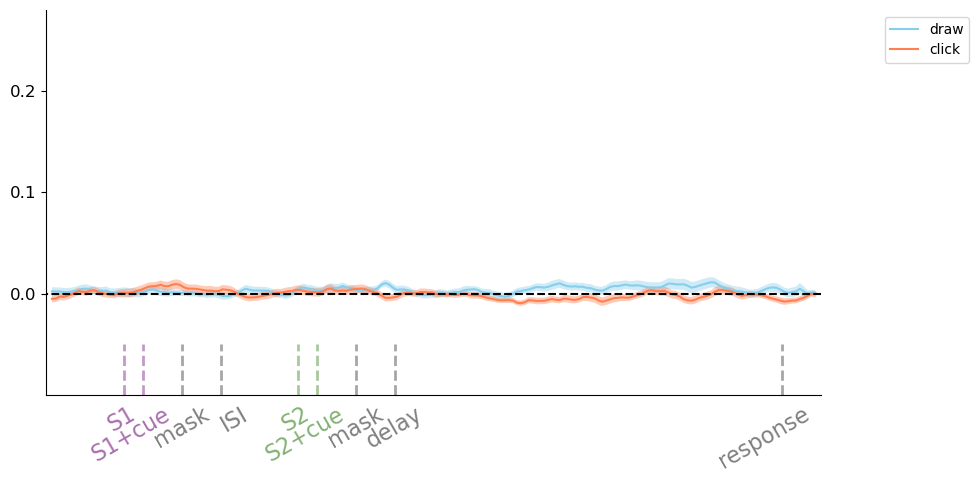

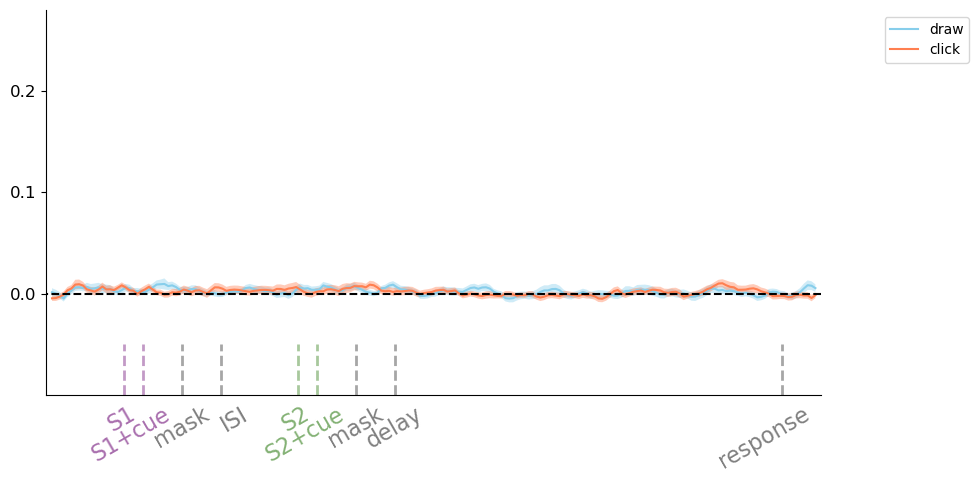

In [30]:
display_gaze_rsa_plots(
    feature_masks=SD_FEATURE_MASKS,
    feature_mask_dist_methods=SD_FEATURE_MASK_DIST_METHODS,
    lmb_masks=sd_mode_masks, 
    color_dicts=sd_mode_colors, 
    alpha_dicts=sd_alphas, 
    linestyles_dicts=sd_linestyles,
    plot_name='last-resp', 
    compare_pairs=True)

In [31]:
s1_cued_only = lambda df: ((df['trial_code']==0) & (df['stim_1_to_report']) & ~(df['stim_2_to_report'])).to_numpy()
both_cued_lmb = lambda df: ((df['trial_code']==0) & (df['stim_1_to_report']) & (df['stim_2_to_report'])).to_numpy()
null_cue_lmb = lambda df: (df['trial_code']==1).to_numpy()

### Split by SD distance

In [32]:
from collections import OrderedDict

def series_angular_diff(x1, x2):
    diffs = np.abs(x1.to_numpy() - x2.to_numpy())
    diffs_2 = 180 - diffs
    actual_diffs = np.min([diffs, diffs_2], axis=0)
    return actual_diffs

sd_masks = {}
sd_val_groups = OrderedDict([
    ('small', (0, 30)),
    ('small-medium', (15, 45)),
    ('medium', (30, 60)),
    ('medium-large', (45, 75)),
    ('large', (60, 90)),
])
for stimid in ['stim_1', 'stim_2']:
    stim_sd_masks = sd_masks.setdefault(stimid, {})
    for sd_name, (low, high) in sd_val_groups.items():
        stim_sd_masks[f'{sd_name}'] = (lambda d, low=low, high=high, stimid=stimid: 
            (
                (series_angular_diff(d[stimid], d['prev_last_response']) >= low) &
                (series_angular_diff(d[stimid], d['prev_last_response']) < high) &
                (d[f'{stimid}_to_report'] | (d['trial_code'] == 1))
            ).to_numpy()
        )

In [33]:
exp_csv = pd.read_csv(os.path.join(DEFAULT_FEATURE_FOLDER, '908', 'behavior.csv'))
print(exp_csv[['stim_1', 'prev_last_response']].head())
exp_mask_lmb = sd_masks['stim_1']['large']
exp_mask = exp_mask_lmb(exp_csv)
print(exp_csv[exp_mask][['stim_1', 'prev_last_response']].head())

       stim_1  prev_last_response
0   53.768502                 NaN
1   95.392638                54.0
2  169.828842               148.0
3   59.178761               163.0
4  114.967475                53.0
       stim_1  prev_last_response
3   59.178761               163.0
8   62.542754               168.0
16  94.165023                22.0
18  69.226384               161.0
19  79.673512                13.0


In [34]:
def plot_stim_sd_rsa(feature_name, target_stim_id, target_stim_name, cmap):
    # set color scale
    condition_shades = [cmap(i) for i in np.linspace(0.3, 0.8, len(sd_val_groups))]
    condition_shades = dict(zip(sd_val_groups.keys(), condition_shades))

    # prepare masks and colors
    sd_ft_masks = {
        feature_name: SD_FEATURE_MASKS[feature_name],
    }
    sd_ft_dist_methods = {
        feature_name: SD_FEATURE_MASK_DIST_METHODS[feature_name],
    }

    sd_lmb_masks = {
        target_stim_id: sd_masks[target_stim_id],
    }
    sd_colors = {
        target_stim_id: condition_shades,
    }
    sd_alphas = {
        target_stim_id: {k: 1.0 for k in condition_shades.keys()},
    }
    sd_linestyles = {
        target_stim_id: {k: '-' for k in condition_shades.keys()},
    }


    display_gaze_rsa_plots(
        feature_masks=sd_ft_masks,
        feature_mask_dist_methods=sd_ft_dist_methods,
        lmb_masks=sd_lmb_masks, 
        color_dicts=sd_colors, 
        alpha_dicts=sd_alphas, 
        linestyles_dicts=sd_linestyles,
        plot_name=f'sd_{target_stim_name}', 
        compare_pairs=False)

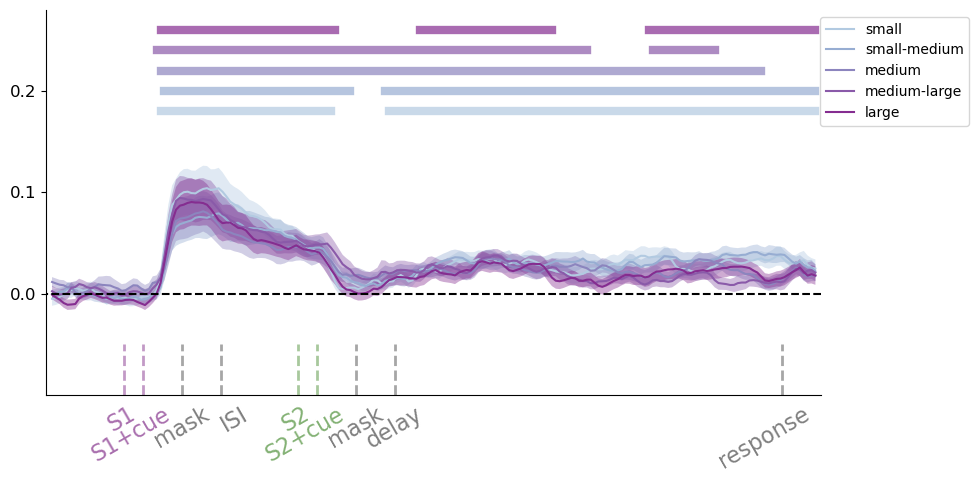

In [35]:
cmap = plt.get_cmap("BuPu")
plot_stim_sd_rsa('mean location', 'stim_1', 'stim 1', cmap)

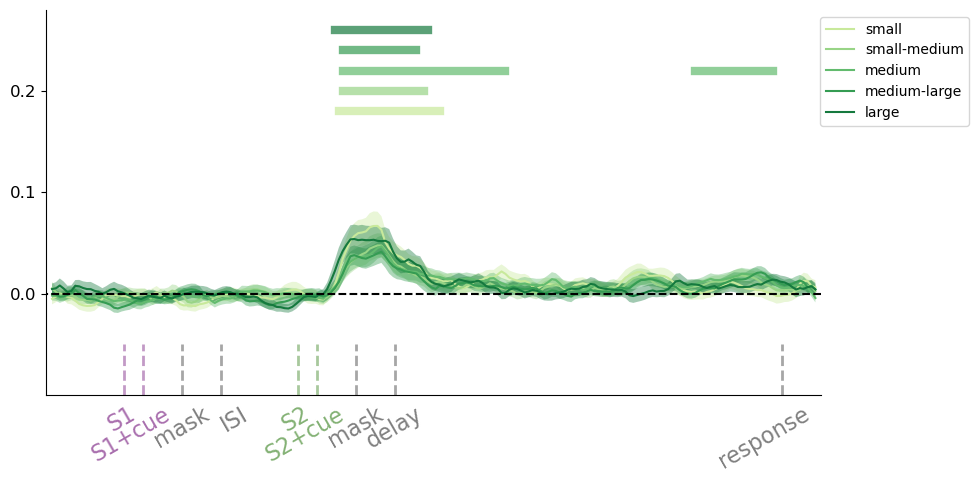

In [36]:
cmap = plt.get_cmap("YlGn")
plot_stim_sd_rsa('mean location', 'stim_2', 'stim 2', cmap)